### Importacion de librerias y seteo de semillas

In [55]:
import json
import os
import pandas as pd
import re, random, math, os
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from datasets import load_dataset
from tqdm import tqdm

from sklearn.model_selection import train_test_split #lo usamos porq nos separa con clases balanceadas

In [56]:
current_dir = "C:\\Users\\mosca\\Documents\\Maestria\\Tercer_trimestre\\AA2\\TP_AA2\\tp_aa_2"

In [57]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

True
12.4
NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [58]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### Importamos la data

In [ ]:
def cargar_reviews(current_dir,nombre_archivo="yelp_academic_dataset_review.json"):

    """
    Carga un archivo de reseñas JSON y devuelve un df de pandas.
    """
    path = os.path.join(current_dir, "yelp_dataset", nombre_archivo)
    print(f"Leyendo archivo desde: {path}")

        
    reviews = []
    _word_re = re.compile(r"[A-Za-z0-9]+", re.UNICODE)
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):

            # ### Solo para empezar a trabajar la data
            # if i >= 100:   # detener después de 'limit' líneas
            #     break

            line = line.strip()
            if line:  # ignora líneas vacías
                dicc=json.loads(line)
                
                #para evitar tener reviews vacias
                if len(_word_re.findall(dicc['text'])) == 0: 
                    continue

                # nos quedamos con la data que queremos
                for key in ['review_id','funny','cool','useful','date']:
                    del dicc[f'{key}']
                reviews.append(dicc)
    
    print(f"Se cargaron {len(reviews)} reseñas desde {path}")


    rv_df = pd.DataFrame(reviews)
    # Convertir stars a int
    rv_df["stars"] = rv_df["stars"].astype(int)
    # Restar 1 para que queden entre 0 y 4
    rv_df["stars"] = rv_df["stars"] - 1

    return rv_df

In [60]:
reviews=cargar_reviews(current_dir)
reviews.head()

Leyendo archivo desde: C:\Users\mosca\Documents\Maestria\Tercer_trimestre\AA2\TP_AA2\tp_aa_2\yelp_dataset\yelp_academic_dataset_review.json
Se cargaron 6990099 reseñas desde C:\Users\mosca\Documents\Maestria\Tercer_trimestre\AA2\TP_AA2\tp_aa_2\yelp_dataset\yelp_academic_dataset_review.json


,user_id,business_id,stars,text
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,2,"If you decide to eat here, just be aware it is..."
1,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,4,I've taken a lot of spin classes over the year...
2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,2,Family diner. Had the buffet. Eclectic assortm...
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,4,"Wow! Yummy, different, delicious. Our favo..."
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,3,Cute interior and owner (?) gave us tour of up...


In [61]:
# Hiperparámetros principales
BATCH_SIZE   = 64
NUM_EPOCHS   = 4
EMBED_DIM    = 100
HIDDEN_DIM   = 128
NUM_LAYERS   = 1
BIDIR        = False
DROPOUT      = 0.2
MIN_FREQ     = 5           # palabras con freq < MIN_FREQ se mapean a <unk> (supongo q es una balabra rara)
MAX_LEN      = 200         # truncado/padding por secuencia
LR           = 1e-3
NUM_CLASSES = 5

### Empezamso a preparar la data

In [62]:

X = reviews["text"] 
y = reviews["stars"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  #proporción de clases parejo
)

train_df = pd.DataFrame({
    "text": X_train,
    "stars": y_train
})

test_df = pd.DataFrame({
    "text": X_test,
    "stars": y_test
})

train_ds = train_df.to_dict(orient="records")
test_ds = test_df.to_dict(orient="records")


In [63]:
# Tokenización simple por palabras, lowercase, sin signos
_word_re = re.compile(r"\b\w+\b", re.UNICODE)
def tokenize(text: str):
    return _word_re.findall(text.lower())


# Construcción de vocab a partir del split de train -> me cuenta las veces que aparece cada palabra el counter
counter = Counter()
for ex in train_ds:
    counter.update(tokenize(ex["text"]))

# aca creo una lista con todas als apalabras que superan la freciuencia minima y la enumero en stoi
specials = ["<pad>", "<unk>"]
itos = specials + [tok for tok, c in counter.items() if c >= MIN_FREQ]
stoi = {tok: i for i, tok in enumerate(itos)}
PAD_IDX = stoi["<pad>"]
UNK_IDX = stoi["<unk>"] # LO QUE SE MAPEA LO Q NO SE VIO NUNCA
print("Vocab size:", len(itos))



#funcion que me pasa un texto a su traduccion en IDs
def text_to_ids(text: str):
    ids = [stoi.get(tok, UNK_IDX) for tok in tokenize(text)]
    # truncado a MAX_LEN
    if len(ids) > MAX_LEN:
        ids = ids[:MAX_LEN]
    return torch.tensor(ids, dtype=torch.long)

Vocab size: 144022


In [64]:
# --------------------------
# 3) Dataset y collate_fn
# --------------------------
class NewsDataset(Dataset):
    def __init__(self, hf_split):
        self.data = hf_split

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ex = self.data[int(idx)]
        label = int(ex["stars"])    #Lo modificamos asi agarra la cantidad de estrellas
        text_ids = text_to_ids(ex["text"])
        return text_ids, label

def collate_fn(batch):
    # batch: lista de (tensor_ids, label_int)
    seqs, labels = zip(*batch)
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    

    # padding a la derecha hasta MAX_LEN
    padded = nn.utils.rnn.pad_sequence(seqs, batch_first=True, padding_value=PAD_IDX)
    if padded.size(1) < MAX_LEN:
        pad_extra = torch.full((padded.size(0), MAX_LEN - padded.size(1)), PAD_IDX, dtype=torch.long)
        padded = torch.cat([padded, pad_extra], dim=1)
    elif padded.size(1) > MAX_LEN:
        padded = padded[:, :MAX_LEN]
        lengths = torch.clamp(lengths, max=MAX_LEN)

    y = torch.tensor(labels, dtype=torch.long)
    return padded, lengths, y

train_loader = DataLoader(NewsDataset(train_ds), batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
test_loader  = DataLoader(NewsDataset(test_ds),  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [65]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes,
                 num_layers=1, bidirectional=False, dropout=0.0, pad_idx=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Linear(out_dim, num_classes)

        # Inicialización estable
        nn.init.xavier_uniform_(self.embedding.weight)
        with torch.no_grad():
            if pad_idx is not None:
                self.embedding.weight[pad_idx].fill_(0)

    def forward(self, x, lengths):
        # x: [B, T], lengths: [B]
        emb = self.embedding(x)  # [B, T, E]
        packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)  # h_n: [L*(2 if bi), B, H]

        if self.lstm.bidirectional:
            last_hidden = torch.cat((h_n[-2], h_n[-1]), dim=1)  # [B, 2H]
        else:
            last_hidden = h_n[-1]  # [B, H]

        logits = self.fc(last_hidden)  # [B, C]
        return logits

model = LSTMClassifier(
    vocab_size=len(itos),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIR,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [66]:
# --------------------------
# 5) Entrenamiento
# --------------------------


train_accuracies_epoch=[]
test_accuracies_epoch=[]


for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]")
    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{NUM_EPOCHS}")

    correct = 0
    total = 0
    for X, lengths, y in loop:
        X, lengths, y = X.to(device), lengths.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X, lengths)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

        # Accuracy batch
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    
    epoch_acc = correct / total
    train_accuracies_epoch.append(epoch_acc)


    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for X, lengths, y in test_loader:
            X, lengths, y = X.to(device), lengths.to(device), y.to(device)
            logits = model(X, lengths)
            loss = criterion(logits, y)

            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    val_acc = correct / total
    test_accuracies_epoch.append(val_acc)
    model.train()

Epoch [1/4]


Epoch 0/4:  12%|█▏        | 10594/87377 [03:44<27:08, 47.14it/s, loss=0.546]


KeyboardInterrupt: 

In [ ]:
# --------------------------
# 6) Evaluación
# --------------------------
def check_accuracy(loader, model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, lengths, y in loader:
            X, lengths, y = X.to(device), lengths.to(device), y.to(device)
            logits = model(X, lengths)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total   += y.size(0)
    acc = 100.0 * correct / total
    model.train()
    return acc
train_acc = check_accuracy(train_loader, model)
test_acc  = check_accuracy(test_loader, model)


print(f"Train accuracy: {train_acc:.2f}%")
print(f"Test  accuracy: {test_acc:.2f}%")

Train accuracy: 48.75%
Test  accuracy: 50.00%


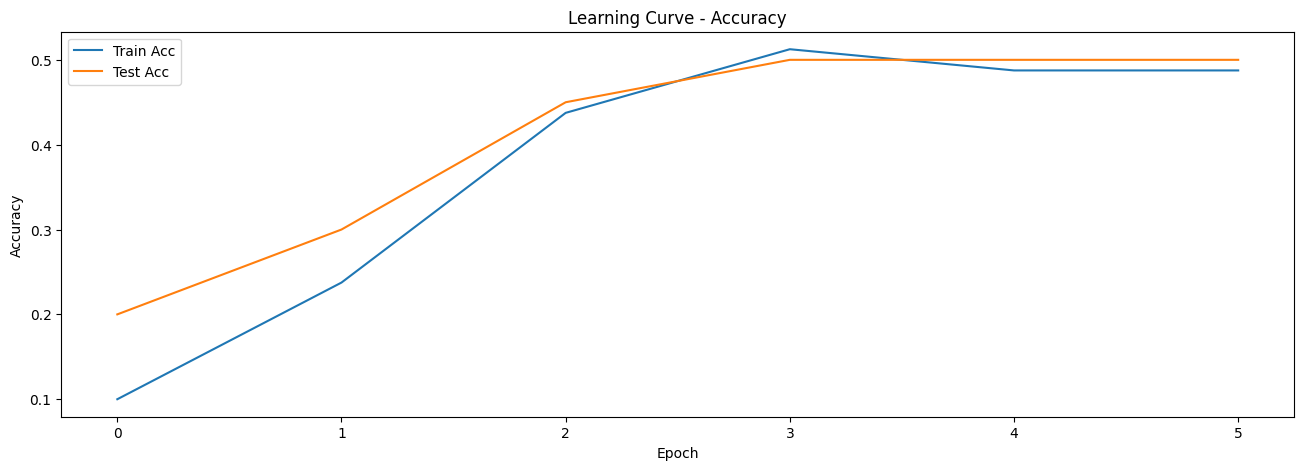

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(35,5))


# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies_epoch, label='Train Acc')
plt.plot(test_accuracies_epoch, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Accuracy')
plt.legend()

plt.show()